# LoRA Fine-Tuning on FLUX.2 Klein Base
## From Theory to Real Results

---

### What Makes This Workshop Different

We're not just explaining LoRA — we trained one live and will show you exactly what happened.

**Today's Demo:** Teaching Klein Base 4B to transform regular cars into custom "pimped" versions.

| | |
|---|---|
| **Model** | FLUX.2 Klein Base 4B |
| **Dataset** | 44 car transformation pairs |
| **Training** | 500 steps, ~15 minutes |
| **Result** | Working i2i transformation LoRA |

---

### Workshop Structure (45 min)

```
Part 1: Why Klein Base?              (8 min)
        Flow matching vs DDPM, dual-stream architecture

Part 2: LoRA Deep Dive              (20 min)
        Mechanics, PEFT methods (DoRA, LoKr), layer analysis,
        merging, text encoder tuning, targeting strategies

Part 3: Live Training Results       (10 min)
        Our actual training run, loss analysis, what we learned

Part 4: Practical Playbook           (7 min)
        Configs by use case, troubleshooting reference
```

In [47]:
# Setup for demo images only
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('dark_background')
plt.rcParams.update({'figure.facecolor': '#0f0f0f', 'axes.facecolor': '#0f0f0f'})

SAMPLES_DIR = Path('samples')
DATA_DIR = Path('training_data')

print('Ready')

Ready


---
# Part 1: Why Klein Base?

## Undistilled = Better for Fine-Tuning

Klein Base hasn't been compressed for faster inference. That preserved capacity is exactly what we want for teaching new concepts.

| Model | Distilled? | Fine-tuning | Inference |
|-------|------------|-------------|----------|
| Klein Base 4B | No | Better | Slower |
| Schnell | Yes | Worse | Faster |

## Flow Matching ≠ DDPM

Most LoRA tutorials assume DDPM. Klein uses **flow matching** — this changes how training works.

![Flow Matching vs DDPM](assets/flow_vs_ddpm.svg)

## Klein's Dual-Stream Architecture

Not all transformer blocks are equal. Klein has two types — and where you apply LoRA matters:

- **Double-stream blocks (5)**: Text and image processed separately, then cross-attend
- **Single-stream blocks (20)**: Concatenated image+text processed jointly

![Klein Architecture](assets/klein_architecture.svg)

---
# Part 2: LoRA Deep Dive

## The Core Idea

Instead of updating 4B parameters, we add small adapter matrices:

```
W' = W + BA
     └─frozen─┘  └─trained─┘
```

- **B** starts at zero → LoRA has no effect initially
- Gradually learns the new concept
- **Why it works:** Fine-tuning updates tend to be low-rank

![LoRA Decomposition](assets/lora_decomposition.svg)

## Key Hyperparameters

| Parameter | What it controls | Typical range |
|-----------|-----------------|---------------|
| **rank** | Capacity to learn | 8-64 |
| **alpha** | Scaling factor | Usually = rank |
| **lr** | Learning speed | 1e-4 to 3e-4 |
| **steps** | Training duration | 250-1500 |

The effective LoRA strength is `alpha / rank`. When alpha = rank, scaling = 1.0.

## Beyond Vanilla LoRA: PEFT Methods Compared

LoRA isn't the only parameter-efficient method. Here's how the options compare:

![PEFT Comparison](assets/peft_comparison.svg)

## Layer-wise Analysis: What Gets Learned Where

Not all transformer blocks learn the same things. Understanding this helps you:
- Debug training issues
- Design targeted LoRA configs
- Understand what your model learned

![Layer Analysis](assets/layer_analysis.svg)

## LoRA Composition and Merging

One of LoRA's killer features: combine multiple LoRAs at inference time.

**But this has caveats.**

![LoRA Merging](assets/lora_merging.svg)

## Text Encoder vs Transformer Fine-tuning

You can apply LoRA to the text encoder (Qwen3) too. When should you?

![Text Encoder Tuning](assets/text_encoder_tuning.svg)

---
# Part 3: Live Training Results

## The Task: Pimp My Ride

We trained Klein Base to transform regular cars into custom "pimped" versions.

**Training Config:**
```yaml
model: FLUX.2-Klein-Base-4B
rank: 32, alpha: 32
lr: 1e-4
steps: 500
dataset: 44 image pairs
```

## The Training Data

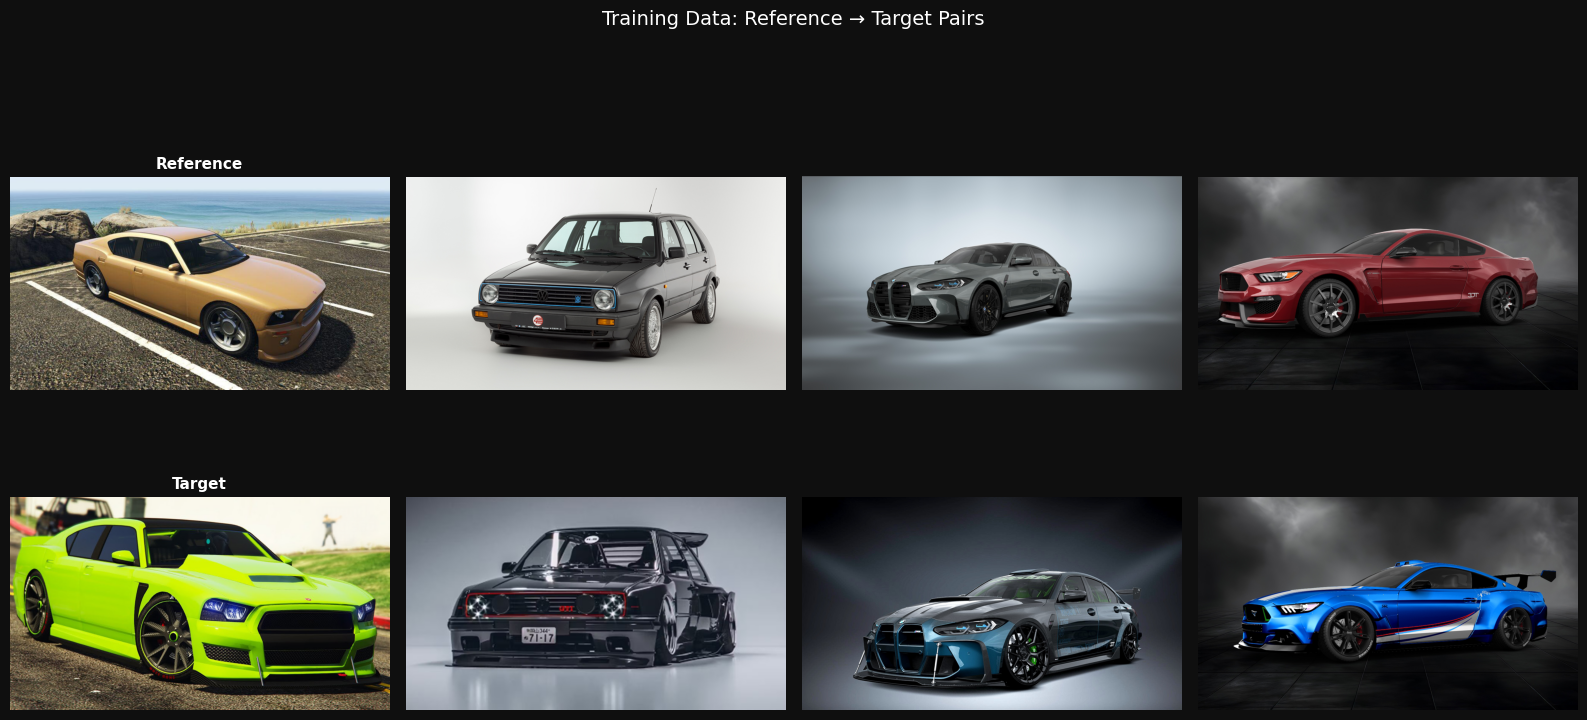

Dataset: 44 pairs | Diverse car types | Unique captions per image


In [44]:
# Training data samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
pairs = ['001', '003', '017', '037']

for i, idx in enumerate(pairs):
    ref_path = DATA_DIR / 'pimpmyride_control' / f'{idx}.png'
    if ref_path.exists():
        axes[0, i].imshow(Image.open(ref_path))
    axes[0, i].axis('off')
    axes[0, i].set_title('Reference' if i == 0 else '', fontsize=11, color='white')
    
    tgt_path = DATA_DIR / 'pimpmyride' / f'{idx}.png'
    if tgt_path.exists():
        axes[1, i].imshow(Image.open(tgt_path))
    axes[1, i].axis('off')
    axes[1, i].set_title('Target' if i == 0 else '', fontsize=11, color='white')

plt.suptitle('Training Data: Reference → Target Pairs', fontsize=14, y=1.02, color='white')
plt.tight_layout()
plt.show()
print("Dataset: 44 pairs | Diverse car types | Unique captions per image")

## Training Progression

Here's what the model generated at each checkpoint. Same prompt throughout:

`"pimpmyride, a sports car"`

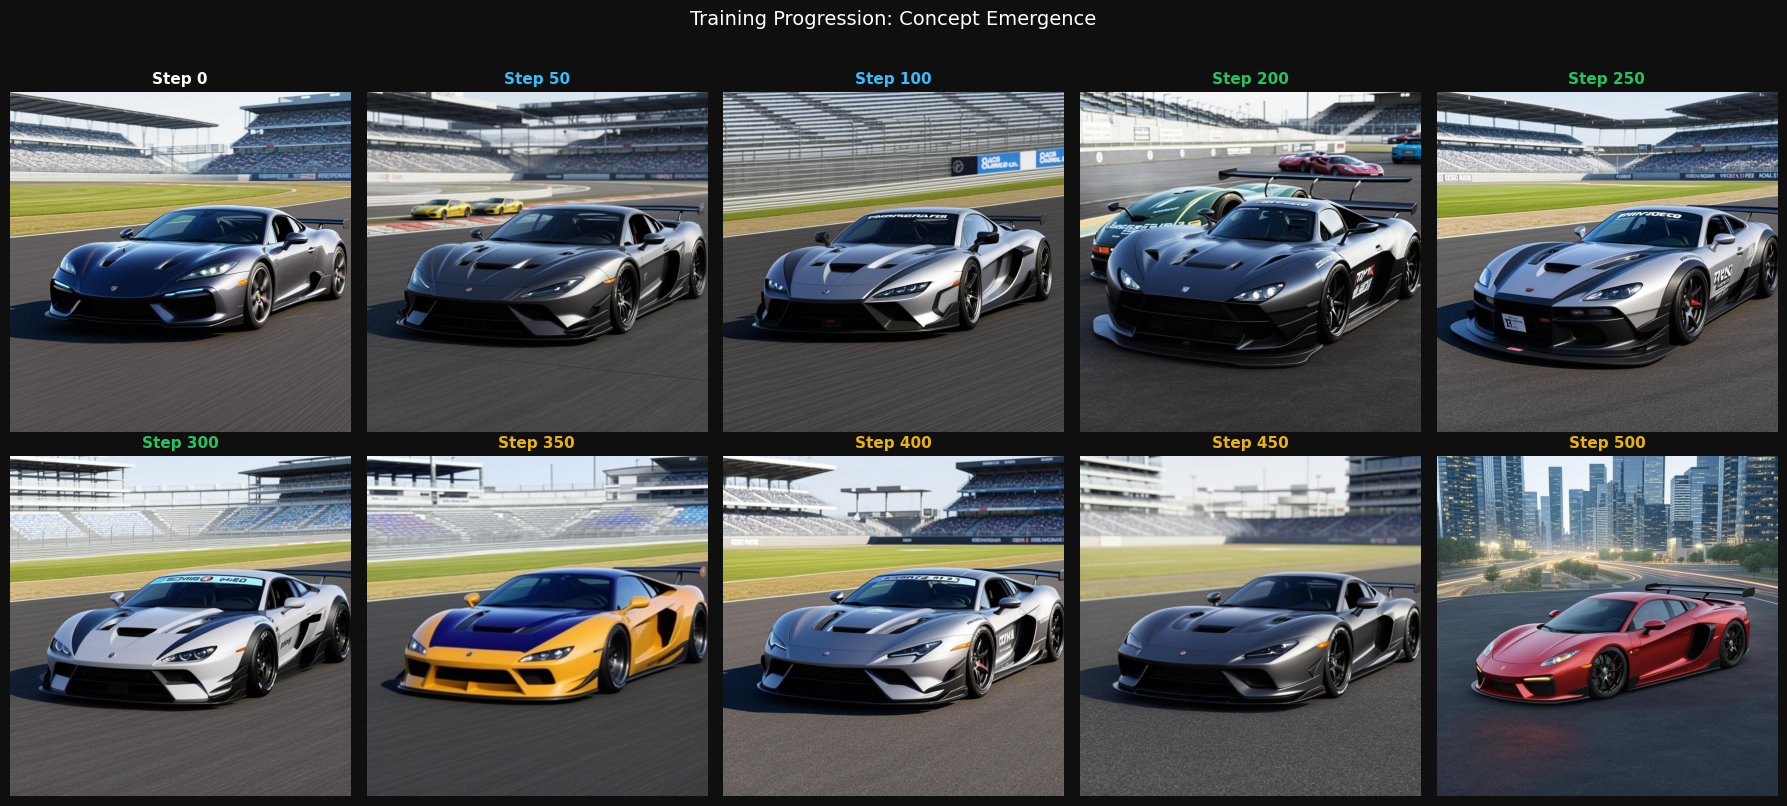

In [45]:
# Training progression
fig, axes = plt.subplots(2, 5, figsize=(18, 8))

step_files = {
    0: '1768946967141__000000000_0.jpg',
    50: '1768947077803__000000050_0.jpg',
    100: '1768947186514__000000100_0.jpg',
    200: '1768947404491__000000200_0.jpg',
    250: '1768947514157__000000250_0.jpg',
    300: '1768947621817__000000300_0.jpg',
    350: '1768947732234__000000350_0.jpg',
    400: '1768947841399__000000400_0.jpg',
    450: '1768947950571__000000450_0.jpg',
    500: '1768948054553__000000500_0.jpg',
}

steps = [0, 50, 100, 200, 250, 300, 350, 400, 450, 500]
colors = {'early': '#38bdf8', 'learning': '#22c55e', 'converging': '#eab308'}

for i, step in enumerate(steps):
    row, col = i // 5, i % 5
    ax = axes[row, col]
    
    img_path = SAMPLES_DIR / step_files[step]
    if img_path.exists():
        ax.imshow(Image.open(img_path))
    
    color = 'white' if step == 0 else colors['early'] if step <= 100 else colors['learning'] if step <= 300 else colors['converging']
    ax.set_title(f'Step {step}', fontsize=11, color=color)
    ax.axis('off')

plt.suptitle('Training Progression: Concept Emergence', fontsize=14, y=1.02, color='white')
plt.tight_layout()
plt.show()

## Loss Curve Analysis

What the numbers tell us:

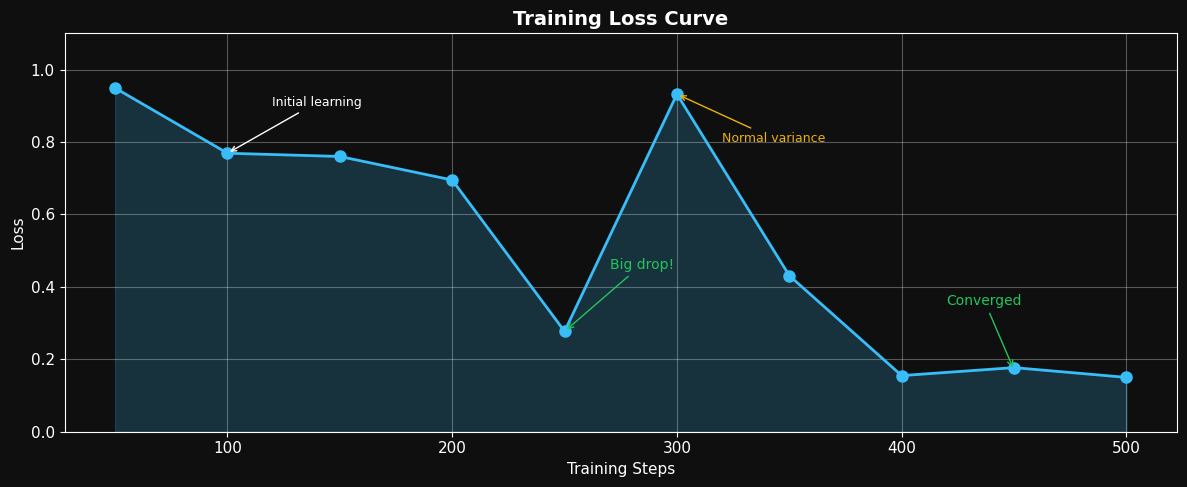

Observations:
  • Step 0-100: Model picking up basic concept
  • Step 200-250: Major breakthrough — concept locks in
  • Step 300 spike: Normal with batch=1 (variance)
  • Step 400+: Converged — could stop here


In [46]:
# Loss curve
steps = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
losses = [0.949, 0.769, 0.760, 0.695, 0.277, 0.932, 0.431, 0.155, 0.177, 0.15]

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(steps, losses, 'o-', color='#38bdf8', lw=2, markersize=8)
ax.fill_between(steps, losses, alpha=0.2, color='#38bdf8')

ax.annotate('Initial learning', xy=(100, 0.769), xytext=(120, 0.9),
           arrowprops=dict(arrowstyle='->', color='white'), fontsize=9, color='white')
ax.annotate('Big drop!', xy=(250, 0.277), xytext=(270, 0.45),
           arrowprops=dict(arrowstyle='->', color='#22c55e'), fontsize=10, color='#22c55e')
ax.annotate('Normal variance', xy=(300, 0.932), xytext=(320, 0.8),
           arrowprops=dict(arrowstyle='->', color='#eab308'), fontsize=9, color='#eab308')
ax.annotate('Converged', xy=(450, 0.17), xytext=(420, 0.35),
           arrowprops=dict(arrowstyle='->', color='#22c55e'), fontsize=10, color='#22c55e')

ax.set_xlabel('Training Steps', color='white')
ax.set_ylabel('Loss', color='white')
ax.set_title('Training Loss Curve', fontsize=14, color='white')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)
plt.tight_layout()
plt.show()

print("Observations:")
print("  • Step 0-100: Model picking up basic concept")
print("  • Step 200-250: Major breakthrough — concept locks in")
print("  • Step 300 spike: Normal with batch=1 (variance)")
print("  • Step 400+: Converged — could stop here")

---
# Part 4: Practical Playbook

## Starting Configurations

```
╔══════════════════════════════════════════════════════════════════════╗
║                    KLEIN BASE 4B CONFIGURATIONS                      ║
╠══════════════════════════════════════════════════════════════════════╣
║                                                                      ║
║  STYLE TRANSFER                    CHARACTER/FACE                    ║
║  ─────────────                     ──────────────                    ║
║  rank: 16        lr: 3e-4          rank: 32        lr: 2e-4          ║
║  alpha: 16       steps: 500-800    alpha: 32       steps: 800-1200   ║
║  data: 50-200 images               data: 20-50 images                ║
║                                                                      ║
║  OBJECT/PRODUCT                    I2I TRANSFORMATION                ║
║  ──────────────                    ──────────────────                ║
║  rank: 24        lr: 2e-4          rank: 32        lr: 1e-4          ║
║  alpha: 24       steps: 600-1000   alpha: 32       steps: 250-500    ║
║  data: 30-100 images               data: 30-100 pairs                ║
║                                                                      ║
╠══════════════════════════════════════════════════════════════════════╣
║  UNIVERSAL SETTINGS                                                  ║
║  ─────────────────                                                   ║
║  optimizer: adamw8bit              scheduler: flowmatch              ║
║  batch_size: 1                     precision: bf16                   ║
║  guidance: 4.0                     timestep: weighted                ║
╚══════════════════════════════════════════════════════════════════════╝
```

## Troubleshooting Guide

![Troubleshooting](assets/troubleshooting.svg)

---
# Summary

### Key Takeaways

1. **Flow matching changes the game** — Klein Base's velocity prediction means more stable training without SNR weighting hacks

2. **Architecture matters** — Double-stream blocks (0-4) handle text↔image binding, single-stream (5-24) handles visual features

3. **Beyond vanilla LoRA** — DoRA gives ~5-10% better text alignment; LoKr uses fewer params; choose based on your needs

4. **Layer-wise understanding** — Early layers = style/color, middle = features/identity, late = composition

5. **Merging works when orthogonal** — Different triggers, different aspects. Fails when concepts conflict.

6. **Text encoder LoRA is optional** — 90% of the time, transformer-only is enough

7. **500 steps was enough** — Concept emerged around step 250, stabilized by 400

### Key Insight from Our Demo

> The transformation concept emerged clearly around **step 200-250** — that's when loss dropped and samples showed the "pimped" aesthetic.

### Quick Reference

| Use Case | Rank | LR | Steps |
|----------|------|-----|-------|
| Style | 16 | 3e-4 | 500-800 |
| Character | 32 | 2e-4 | 800-1200 |
| Object | 24 | 2e-4 | 600-1000 |
| i2i Transform | 32 | 1e-4 | 250-500 |

---

*Workshop materials — Black Forest Labs*